In [35]:
# Data information:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Data source
# https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

In [36]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_27164/4004001396.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [37]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url, sep=',', header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

# Data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?', np.nan).dropna()

data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [38]:
# Describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


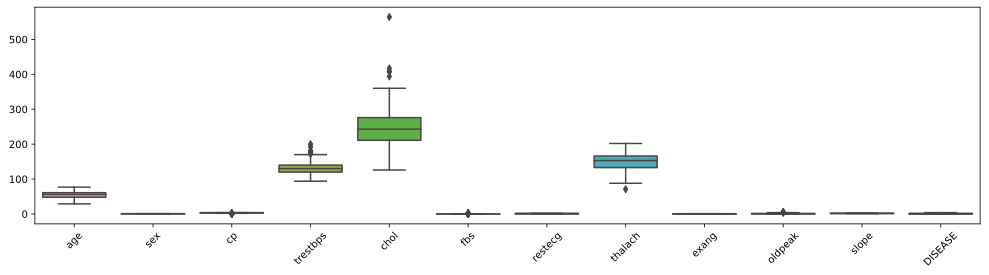

In [39]:
# Check the distributions
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Index(['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak',
       'slope', 'ca', 'thal'],
      dtype='object')


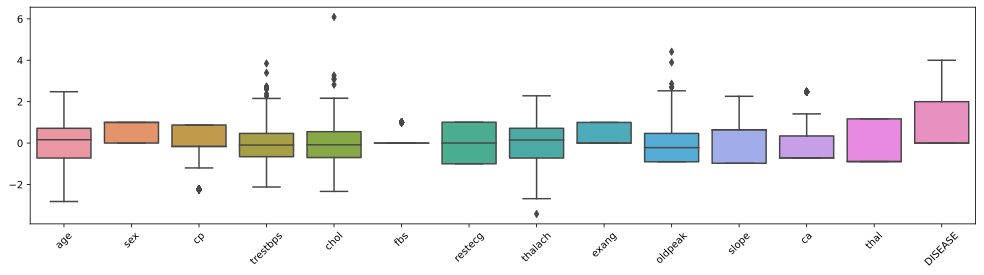

In [41]:
# z-score the non-categorical columns
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop(['sex','fbs','exang','DISEASE'])
print(cols_2_zscore)

for col_2_zscore in cols_2_zscore:
    d = pd.to_numeric(data[col_2_zscore]) # Force to numeric (addresses some data-format issues)
    data[col_2_zscore] = (d - d.mean()) / d.std(ddof=1)

# Check the distributions again
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [42]:
# Count of all unique types of 'DISEASE'
print(data['DISEASE'].value_counts())

# Re-code events to 0 (absent) and 1 (present)
data['DISEASE'][data['DISEASE'] > 0] = 1

0    160
1     54
2     35
3     35
4     13
Name: DISEASE, dtype: int64


C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_27164/2450081334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE'] > 0] = 1


# Re-organize the data: train/test in DataLoaders

In [43]:
# Convert from Pandas Dataframe to tensor
data_tensor   = torch.tensor(data[data.keys().drop('DISEASE')].values).float()
labels_tensor = torch.tensor(data['DISEASE'].values).float()
labels_tensor = labels_tensor[:, None] # We'll actually need the labels to be a "matrix"

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=50)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 20
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {batch_size} samples')

# Sizes of each batch
for data, label in train_loader:
    print(f'BATCH INFO: {data.size()} | {label.size()}\n')

There are 12 batches, each with 20 samples
BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])

BATCH INFO: torch.Size([20, 13]) | torch.Size([20, 1])



# Create a class for the DL model

In [48]:
class the_net(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(13, 32)

        # Hidden layer
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 10)

        # Output layer
        self.output = nn.Linear(10, 1)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [49]:
# Test the model on a bit of data
net = the_net()

X, y  = next(iter(train_loader))
y_hat = net(X)
print(y_hat)

# Test the loss function
loss_func = nn.BCEWithLogitsLoss()
loss_func(y_hat, y)

tensor([[-0.3550],
        [-0.3577],
        [-0.3287],
        [-0.2975],
        [-0.3233],
        [-0.3778],
        [-0.3454],
        [-0.3724],
        [-0.4009],
        [-0.3419],
        [-0.3287],
        [-0.3604],
        [-0.3167],
        [-0.3258],
        [-0.3298],
        [-0.3323],
        [-0.3388],
        [-0.3441],
        [-0.3243],
        [-0.3135]], grad_fn=<AddmmBackward0>)


tensor(0.6983, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Train the model and show performance

In [50]:
# Start with a fresh network
net       = the_net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = nn.BCEWithLogitsLoss()

# Number of training epochs
num_epochs = 100

# Initialize losses and accuracies
train_loss = torch.zeros(num_epochs)
test_loss  = torch.zeros(num_epochs)
train_acc  = torch.zeros(num_epochs)
test_acc   = torch.zeros(num_epochs)

# Loop over epochs
for epoch_i in range(num_epochs):

    # Loop over training data batches
    batch_loss = []

    for X, y in train_loader:

        # Forward pass and loss
        y_hat = net(X)
        loss  = loss_func(y_hat, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from this batch
        batch_loss.append(loss.item())

        # Train accuracy
        predictions        = (torch.sigmoid(y_hat) > 0.5).float()
        train_acc[epoch_i] = 100 * torch.mean((predictions == y).float())

    # End of batch loop...

    # Get average losses across the batches
    train_loss[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y  = next(iter(test_loader))  # Extract x,y from test dataloader
    y_hat = net(X) 

    # Test loss
    loss               = loss_func(y_hat, y)
    test_loss[epoch_i] = loss.item()

    # Test accuracy
    predictions        = (torch.sigmoid(y_hat) > 0.5).float()
    test_acc[epoch_i]  = 100 * torch.mean((predictions == y).float())

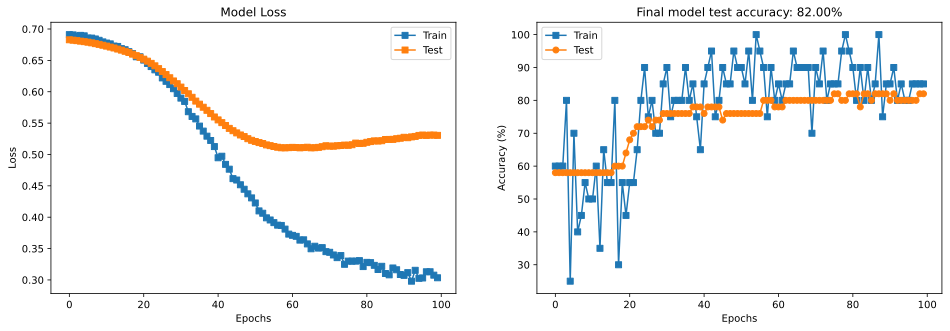

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  's-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(test_acc,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()